# Instalacja pakietów

In [10]:
!pip install -U --no-cache-dir gdown==4.6.0 tensorflow-datasets --pre
!pip install -U --no-cache-dir tensorflow numpy==1.26.4 scikit-learn matplotlib==3.7.3 pillow

# Importy

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import os
import shutil
import zipfile
import glob
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import plotly.express as px


print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.19.0


# Import danych

In [33]:
folder_path = r"/content/data"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path, ignore_errors=True)

import time
time.sleep(1)

os.makedirs(folder_path, exist_ok=True)

with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall(folder_path)

# Hiperparametry

In [56]:
IMAGE_HIGHT = 128
IMAGE_WIDTH = 128

IMAGE_SIZE = (IMAGE_HIGHT, IMAGE_WIDTH)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 6
INIT_LR = 1e-4

# Przegląd danych

In [57]:
train_path = "data/train"
test_path = "data/test"

classes = ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
CLASS_LABELS_EMOJIS = ["👿" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

for el in classes:
    count_train = len(glob.glob(f"{train_path}/{el}/*.png"))
    count_test = len(glob.glob(f"{test_path}/{el}/*.png"))
    print(f"{el.capitalize()}: {count_test + count_train} przykładów; {count_train} treningowych, {count_test} testowych")

Angry: 4953 przykładów; 3995 treningowych, 958 testowych
Fearful: 5121 przykładów; 4097 treningowych, 1024 testowych
Happy: 8989 przykładów; 7215 treningowych, 1774 testowych
Neutral: 6198 przykładów; 4965 treningowych, 1233 testowych
Sad: 6077 przykładów; 4830 treningowych, 1247 testowych
Surprised: 4002 przykładów; 3171 treningowych, 831 testowych


In [58]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                                                validation_split=0.2,
                                                                horizontal_flip=True,
                                                                rotation_range=30,
                                                                brightness_range=[0.7, 1.3],
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                zoom_range=0.2,
                                                                fill_mode='nearest'
                                                                )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training'
)

val_generator = train_datagen.flow_from_directory(directory=train_path,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  subset='validation'
)

test_generator = test_datagen.flow_from_directory(directory=test_path,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False
                                                  )

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [ ]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Found 28273 images belonging to 6 classes.


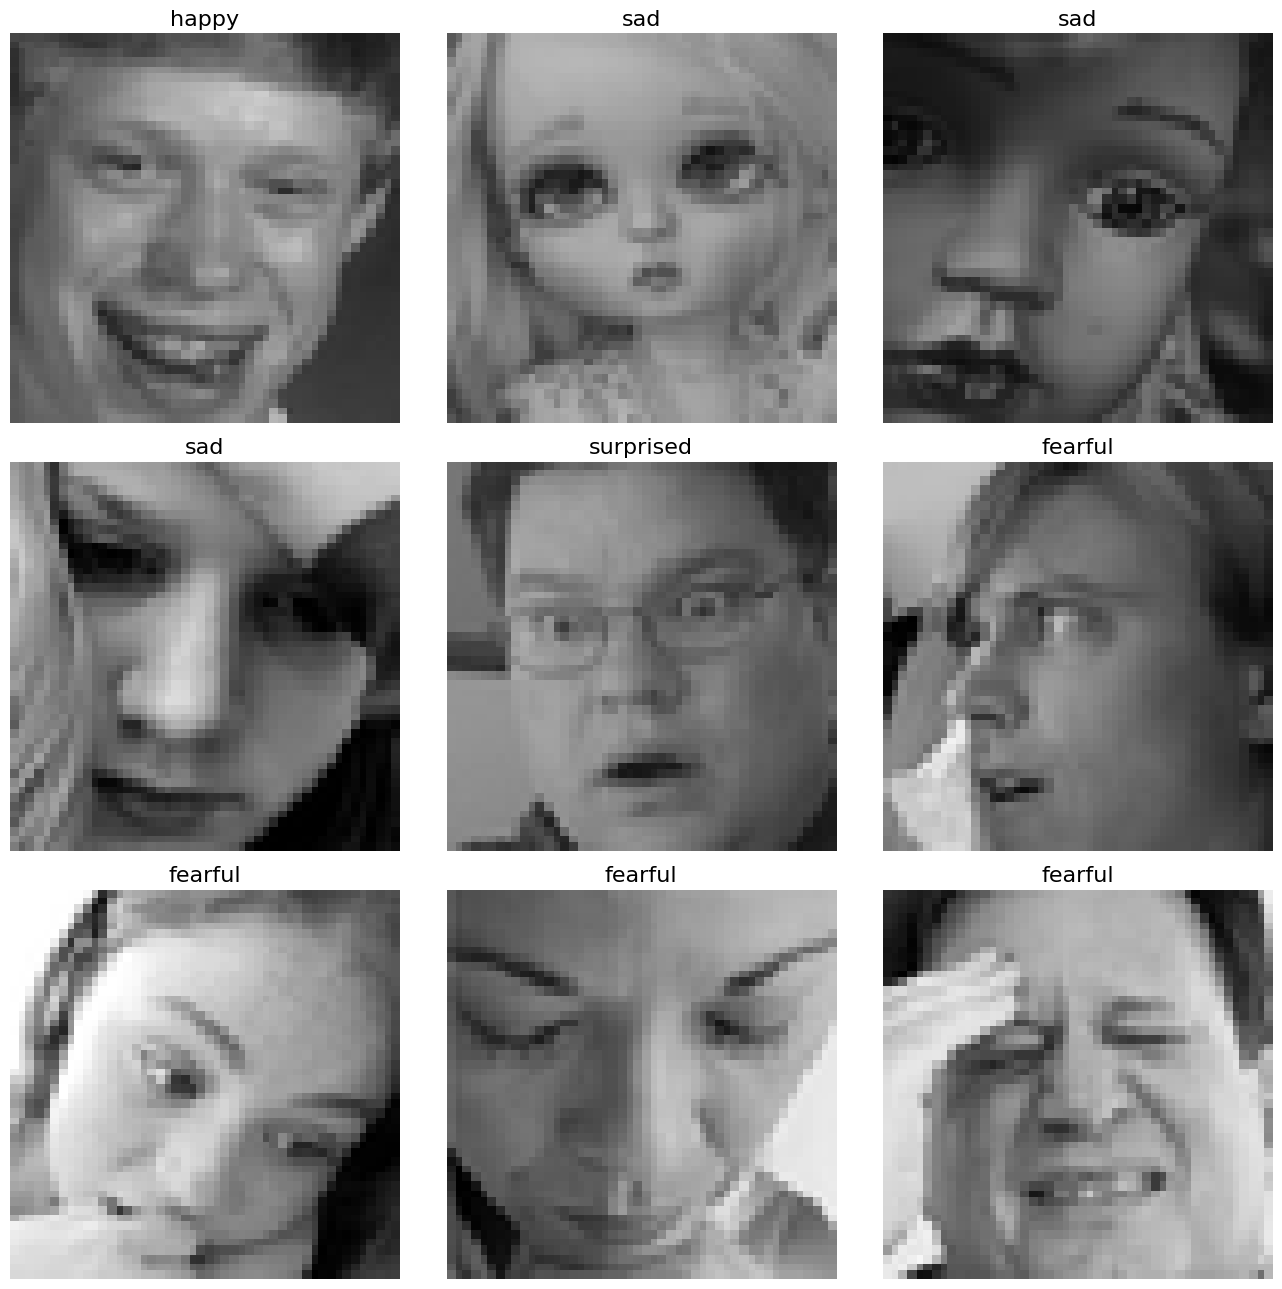

In [59]:
img_datagen = ImageDataGenerator(rescale=1./255)
img_generator = img_datagen.flow_from_directory(
    directory='data/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    seed=12
)

def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

images, labels = next(img_generator)
label_indices = np.argmax(labels, axis=1)
class_names = list(train_generator.class_indices.keys())
label_names = [class_names[idx] for idx in label_indices]
display_nine_images(images, label_names)

# Model (podejście transfer learning)

In [60]:
base_model = EfficientNetB2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

model.compile(
    optimizer=optimizers.AdamW(learning_rate=INIT_LR),
    loss=CategoricalCrossentropy(label_smoothing=0.15),
    metrics=['accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 4, 4, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1408)           │         5,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,137,471 (31.04 MB)

 Trainable params: 365,574 (1.39 MB)

 Non-trainable params: 7,771,897 (29.65 MB)

In [61]:
def cosine_decay(epoch):
    min_lr = 1e-5
    return min_lr + 0.5 * (INIT_LR - min_lr) * (1 + math.cos(math.pi * epoch / EPOCHS))

In [62]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    LearningRateScheduler(cosine_decay)
]

In [63]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 209s 236ms/step - accuracy: 0.2079 - loss: 2.7382 - val_accuracy: 0.3831 - val_loss: 1.6971 - learning_rate: 1.0000e-04
Epoch 2/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 125s 176ms/step - accuracy: 0.2802 - loss: 2.2870 - val_accuracy: 0.4094 - val_loss: 1.6222 - learning_rate: 9.9911e-05
Epoch 3/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 124s 176ms/step - accuracy: 0.3022 - loss: 2.0589 - val_accuracy: 0.4238 - val_loss: 1.5836 - learning_rate: 9.9645e-05
Epoch 4/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 125s 177ms/step - accuracy: 0.3098 - loss: 1.9478 - val_accuracy: 0.4257 - val_loss: 1.5699 - learning_rate: 9.9203e-05
Epoch 5/50
213/707 ━━━━━━━━━━━━━━━━━━━━ 1:09 141ms/step - accuracy: 0.3218 - loss: 1.8615

KeyboardInterrupt: 

# Ewaluacja modelu

In [64]:
def plot_train_valid_history(history):
    epochs = np.arange(len(history.history['val_loss'])) + 1
    fig = plt.figure(figsize=(8, 4))
    if 'accuracy' in history.history:
        ax1 = fig.add_subplot(121)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left')
        plt.grid(True)

        ax1 = fig.add_subplot(122)
        ax1.plot(epochs, history.history['accuracy'], c='b', label='Train acc')
        ax1.plot(epochs, history.history['val_accuracy'], c='g', label='Valid acc')
        plt.legend(loc='lower right')
        plt.grid(True)


    else:
        ax1 = fig.add_subplot(111)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left')
        plt.grid(True)
    plt.show()


plot_train_valid_history(history)

NameError: name 'history' is not defined

In [ ]:
model.evaluate(test_generator)

# Zapis modelu

In [ ]:
model.save("/content/model/emotion_model_v9.keras")